# Simulating 1D Trench Flow*

The tool simulates the effect on the water table due to model parameters.

## Scenario and Equation

```{figure} /contents/modeling/lecture_11/images/M11_f4.png
---
scale: 20%
align: center
name: Ditch
---
Conceptual model of a flow between two water bodies separated by unconfined aquifer
```

You can calculate the steady flow in an unconfined aquifer with this Equations<sup>[^Fetter2017]</sup> :

$$q' = \frac{1}{2} \cdot K \cdot \frac{H_o^2-H_u^2}{L}$$

$$h(x)=\sqrt{H_o^2 - \frac{H_o^2-H_u^2}{L} \cdot x+\frac{R}{K} \cdot x \cdot(L-x)}$$

with  
$q'$ = flow per unit width $[m^2/s]$, 
$h$ = head at x $[m]$,  
$x$ = distance from the origin $[m]$, 
$H_o$ = head at the origin $[m]$, 
$H_u$ = head at L $[m]$, 
$L$ = distance from the origin at the point $H_u$ is measured $[m]$, 
$K$ = hydraulic conductivity $[m/s]$, 
$R$ = recharge rate $[m/s]$

[^Fetter2017]: C. W. Fetter, Thomas Boving, David Kreamer (2017), _Contaminant Hydrogeology_: Third Edition, Waveland Press

**_Contributed by Ms. Anne Pförtner and Sophie Pförtner. The original concept from Prof. R. Liedl spreasheet code._**


### How to use this tool ###

1. Go to the Binder by clicking the rocket button (top-right of the page)

2. Execute the code cell with libraries and the code cell

3. Interact with the sliders.

The codes are licensed under CC by 4.0 [(use anyways, but acknowledge the original work)](https://creativecommons.org/licenses/by/4.0/deed.en)

In [3]:
# Initialize librarys
import matplotlib.pyplot as plt
import numpy as np
import math
from ipywidgets import *

In [4]:
# Definition of the function
def head(Ho, Hu, L, R, K):

    """
    Ho: inflow head in [m]
    Hu: outflow head in [m]
    L:  Domain length in [m]
    R:  Recharge rate in [mm/d]
    K: Hydraulic conductivity in [m/s]
    """
    x = np.arange(0, L,L/1000)
    R=R/1000/365.25/86400
    h=(Ho**2-(Ho**2-Hu**2)/L*x+(R/K*x*(L-x)))**0.5
    plt.plot(x, h)
    plt.ylabel('head [m]')
    plt.ylim(0,1.5*Ho)
    plt.xlabel('x [m]')
    plt.xlim(0,L)
    plt.show()

style = {'description_width': 'initial'}  
interact(head,
         Ho=widgets.BoundedFloatText(value=10, min=0, max=1000, step=0.1, description='Ho:', disabled=False),
         Hu=widgets.BoundedFloatText(value=7.5, min=0, max=1000, step=0.1, description='Hu:', disabled=False),
         L= widgets.BoundedFloatText(value=175,min=0, max=10000,step=1, description='L:' , disabled=False),
         R=(-500,2500,10),
         K=widgets.FloatLogSlider(value=0.0002,base=10,min=-6, max=-2, step=0.0001,readout_format='.2e'))

interactive(children=(BoundedFloatText(value=10.0, description='Ho:', max=1000.0, step=0.1), BoundedFloatText(…

<function __main__.head(Ho, Hu, L, R, K)>

In [4]:
R=800/1000/365.25/86400
R 

2.535047025122316e-08

In [22]:

import numpy as np

def steady_1d_dirichlet_no_recharge(L=1000.0, N=201, hL=100.0, hR=95.0, K=1e-4):
    """
    Steady-state confined 1D groundwater flow:
        d²h/dx² = 0  (because K constant & no recharge)
    Dirichlet BCs: h(0)=hL, h(L)=hR
    """
    x = np.linspace(0, L, N)
    dx = x[1] - x[0]

    A = np.zeros((N, N))
    b = np.zeros(N)

    # interior nodes
    for i in range(1, N-1):
        A[i, i-1] = K/dx**2
        A[i, i]   = -2*K/dx**2
        A[i, i+1] = K/dx**2

    # Dirichlet BCs
    A[0,0] = 1;  b[0] = hL
    A[-1,-1] = 1;  b[-1] = hR

    h = np.linalg.solve(A, b)
    return x, h




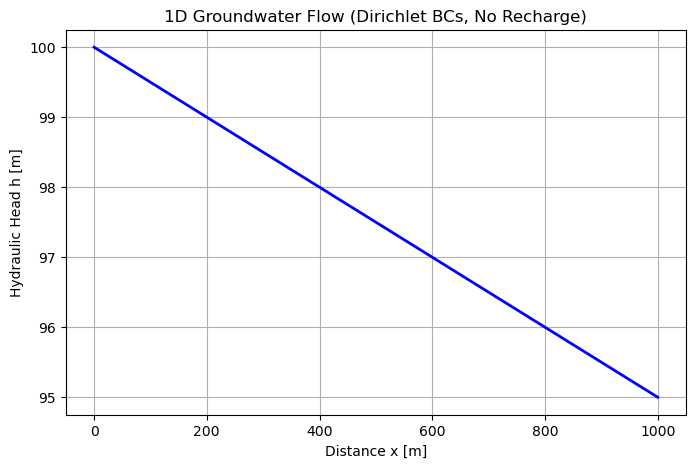

In [23]:

import matplotlib.pyplot as plt

# Solve the problem
x, h = steady_1d_dirichlet_no_recharge()

# Plot
plt.figure(figsize=(8,5))
plt.plot(x, h, 'b-', linewidth=2)
plt.xlabel("Distance x [m]")
plt.ylabel("Hydraulic Head h [m]")
plt.title("1D Groundwater Flow (Dirichlet BCs, No Recharge)")
plt.grid(True)
plt.show()



Converged in 3079 iterations with error 9.99e-07


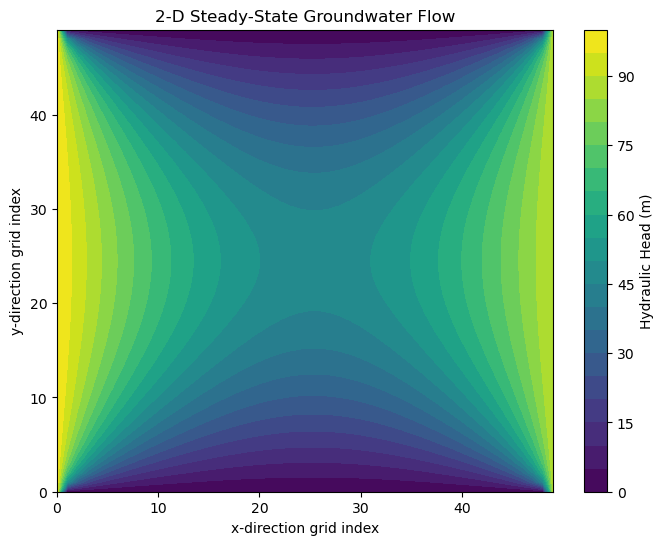

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def groundwater_flow_2d(nx=50, ny=50, Lx=1000, Ly=1000, K=10):
    """
    Solve 2-D steady-state groundwater flow:
        ∂/∂x (K ∂h/∂x) + ∂/∂y (K ∂h/∂y) = 0
    using finite differences on a regular grid.
    
    Parameters:
        nx, ny : number of grid cells in x and y
        Lx, Ly : domain length in x and y (m)
        K      : hydraulic conductivity (m/day)
    """

    # Grid spacing
    dx = Lx / (nx - 1)
    dy = Ly / (ny - 1)

    # Initialize head field
    h = np.zeros((ny, nx))

    # Boundary conditions
    h[:, 0] = 100          # Left boundary (fixed head 100 m)
    h[:, -1] = 90          # Right boundary (fixed head 90 m)
    h[0, :] = h[0, :]      # No-flow implicitly handled inside iterations
    h[-1, :] = h[-1, :]    # No-flow implicitly handled inside iterations

    # Iterative parameters
    max_iter = 5000
    tol = 1e-6

    for it in range(max_iter):
        h_old = h.copy()

        # Update interior nodes using finite difference scheme
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                h[j, i] = 0.5 * (
                    (h[j, i+1] + h[j, i-1]) / dx**2 +
                    (h[j+1, i] + h[j-1, i]) / dy**2
                ) / (1/dx**2 + 1/dy**2)

        # Check convergence
        error = np.max(np.abs(h - h_old))
        if error < tol:
            print(f"Converged in {it} iterations with error {error:.2e}")
            break
    else:
        print("Did not converge")

    return h


# Run the model
h = groundwater_flow_2d()

# Visualization
plt.figure(figsize=(8, 6))
plt.contourf(h, levels=20, cmap='viridis')
plt.colorbar(label='Hydraulic Head (m)')
plt.title("2-D Steady-State Groundwater Flow")
plt.xlabel("x-direction grid index")
plt.ylabel("y-direction grid index")
plt.show()

Converged in 3083 iterations with error 9.98e-07


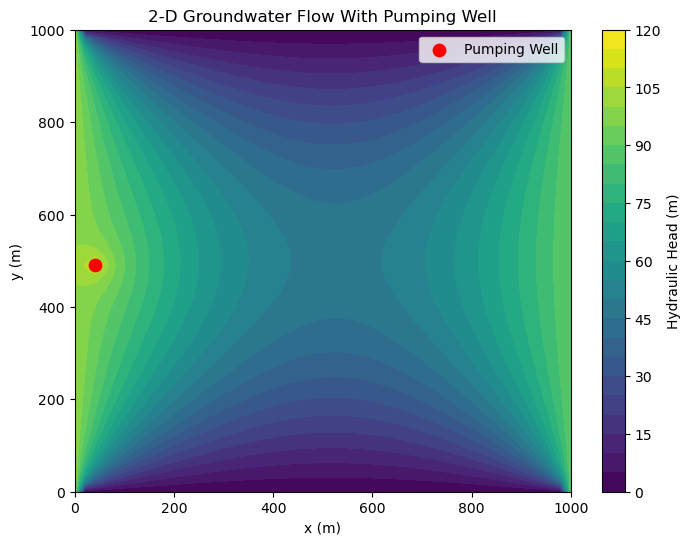

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def groundwater_flow_with_well(nx=50, ny=50, Lx=1000, Ly=1000,
                               K=10, Qw=-500, wx=50, wy=500):
    """
    2-D steady-state groundwater flow with a pumping well.

    PDE:
        ∂/∂x (K ∂h/∂x) + ∂/∂y (K ∂h/∂y) + Q/K = 0

    Parameters:
        nx, ny  : grid cells
        Lx, Ly  : domain length (m)
        K       : hydraulic conductivity (m/day)
        Qw      : pumping rate (m³/day), negative for pumping
        wx, wy  : well location (m)
    """

    dx = Lx / (nx - 1)
    dy = Ly / (ny - 1)

    # Grid
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)

    # Head array
    h = np.zeros((ny, nx))

    # Dirichlet BCs
    h[:, 0] = 100         # left boundary
    h[:, -1] = 90         # right boundary

    # Map well coordinates to nearest grid location
    ix = int(wx / dx)
    iy = int(wy / dy)

    # Source/sink term (Q per cell area)
    cell_area = dx * dy
    Q_term = Qw / (K * cell_area)

    max_iter = 8000
    tol = 1e-6

    for it in range(max_iter):
        h_old = h.copy()

        for j in range(1, ny - 1):
            for i in range(1, nx - 1):

                # Source/sink term only at well cell
                S = Q_term if (i == ix and j == iy) else 0.0

                h[j, i] = 0.5 * (
                    (h[j, i+1] + h[j, i-1]) / dx**2 +
                    (h[j+1, i] + h[j-1, i]) / dy**2 - S
                ) / (1/dx**2 + 1/dy**2)

        # Convergence check
        error = np.max(np.abs(h - h_old))
        if error < tol:
            print(f"Converged in {it} iterations with error {error:.2e}")
            break
    else:
        print("Did not converge")

    return h, x, y, (ix, iy)


# Run model
h, x, y, (ix, iy) = groundwater_flow_with_well()

# Plot results
plt.figure(figsize=(8, 6))
plt.contourf(x, y, h, 25, cmap='viridis')
plt.colorbar(label='Hydraulic Head (m)')
plt.scatter(x[ix], y[iy], c='red', s=80, label='Pumping Well')
plt.title("2-D Groundwater Flow With Pumping Well")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def groundwater_flow_with_well(nx = 50, ny=50, Lx= 1000, Ly= 1000,
                               K= 10, Qw=-500, wx = 500, wy=500):

    dx = Lx / (nx - 1)  # grid spacing in x
    dy = Ly / (ny - 1) # grid spacing in y

    # Grid
    x = np.linspace(0, Lx, nx) # x-coordinates of grid
    y = np.linspace(0, Ly, ny) # y-coordinates of grid

    # Head array
    h = np.zeros((ny, nx)) # initialize head array - all zeros

    # Dirichlet BCs
    h[:, 0] = 100         # left boundary
    h[:, -1] = 90         # right boundary
    h[0, :] = h[0, :]      # No-flow implicitly handled inside iterations
    h[-1, :] = h[-1, :]    # No-flow implicitly handled inside iterations


    # Map well coordinates to nearest grid location
    ix = int(wx / dx) # grid index in x for well    
    iy = int(wy / dy) # grid index in y for well 

    cell_area = dx * dy
    Q_term = Qw / (K * cell_area) # source/sink term (Q per cell area)

    # solver parameters    
    max_iter = 8000 # maximum number of iterations
    tol = 1e-6 # convergence tolerance

    for it in range(max_iter):      
        h_old = h.copy() # store old head values for convergence check

        for j in range(1, ny - 1): # loop over interior nodes in y (first and last rows are boundaries)
            for i in range(1, nx - 1): # loop over interior nodes in x

                # Source/sink term only at well cell
                S = Q_term if (i == ix and j == iy) else 0.0 # if this is the well cell, use Q_term, otherwise 0

                # Update head using finite difference scheme for Poisson equation with source term
                h[j, i] = 0.5 * (
                    (h[j, i+1] + h[j, i-1]) / dx**2 +
                    (h[j+1, i] + h[j-1, i]) / dy**2 - S
                ) / (1/dx**2 + 1/dy**2)

        # Convergence check
        error = np.max(np.abs(h - h_old)) # maximum change in head
        if error < tol: # if converged
            print(f"Converged in {it} iterations with error {error:.2e}")
            break
    else:
        print("Did not converge")

    return h, x, y, (ix, iy)

In [55]:


# Run model
h, x, y, (ix, iy) = groundwater_flow_with_well(nx=50, ny=50, Lx=1000, Ly=1000, K=10, Qw=-500, wx=650, wy=950)



Converged in 3085 iterations with error 9.98e-07


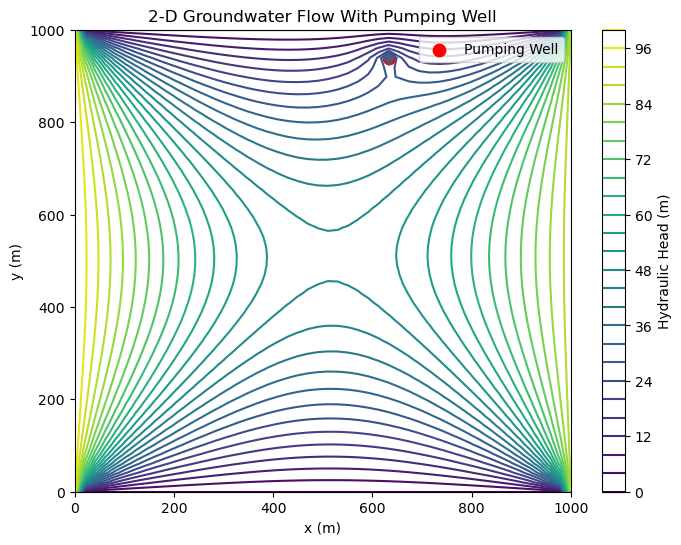

In [56]:
# Plot results
plt.figure(figsize=(8, 6))
plt.contour(x, y, h, 25, cmap='viridis')
plt.colorbar(label='Hydraulic Head (m)')
plt.scatter(x[ix], y[iy], c='red', s=80, label='Pumping Well')
plt.title("2-D Groundwater Flow With Pumping Well")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

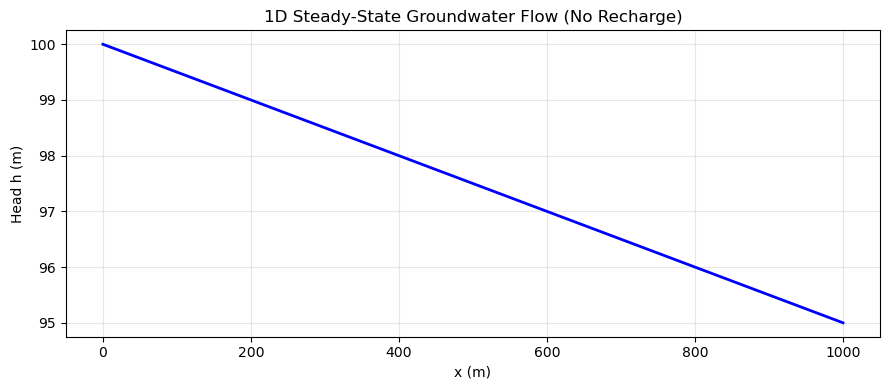

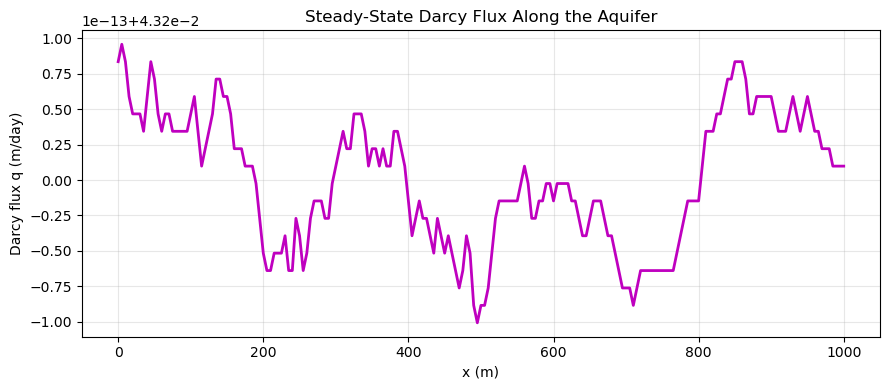

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def steady_1d_groundwater_flow(
    L=1000.0,      # domain length [m]
    nx=201,        # number of nodes
    K=1e-4,        # hydraulic conductivity [m/s]
    b=10.0,        # aquifer thickness [m]
    h0=100.0,      # left boundary head [m]
    hL=95.0        # right boundary head [m]
):
    """
    Steady-state 1D confined groundwater flow (no recharge):
        d/dx (T dh/dx) = 0   with T = K*b.
    Finite-difference solution with Dirichlet BCs at both ends.
    """

    # Grid
    x = np.linspace(0.0, L, nx)
    dx = x[1] - x[0]
    T = K * b   # transmissivity

    # Build linear system A*h = rhs
    A = np.zeros((nx, nx))
    rhs = np.zeros(nx)

    # Interior nodes: T(d2h/dx2)=0 → -T/dx²*h[i-1] + 2T/dx²*h[i] - T/dx²*h[i+1] = 0
    coef = T / dx**2
    for i in range(1, nx - 1):
        A[i, i - 1] = -coef
        A[i, i]     =  2 * coef
        A[i, i + 1] = -coef
        rhs[i]      =  0.0

    # Boundary conditions (Dirichlet)
    A[0, 0] = 1.0
    rhs[0]  = h0

    A[-1, -1] = 1.0
    rhs[-1]   = hL

    # Solve system
    h = np.linalg.solve(A, rhs)

    # Darcy flux q = -K * dh/dx
    q = np.zeros_like(h)
    q[1:-1] = -K * (h[2:] - h[:-2]) / (2 * dx)
    q[0]    = -K * (h[1]  - h[0]) / dx
    q[-1]   = -K * (h[-1] - h[-2]) / dx

    return x, h, q


# ---------------------------
# Run model
# ---------------------------
x, h, q = steady_1d_groundwater_flow()

# ---------------------------
# Plot heads
# ---------------------------
plt.figure(figsize=(9, 4))
plt.plot(x, h, 'b-', lw=2)
plt.xlabel("x (m)")
plt.ylabel("Head h (m)")
plt.title("1D Steady-State Groundwater Flow (No Recharge)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot Darcy flux
# ---------------------------
plt.figure(figsize=(9, 4))
plt.plot(x, q * 86400.0, 'm-', lw=2)   # convert m/s → m/day
plt.xlabel("x (m)")
plt.ylabel("Darcy flux q (m/day)")
plt.title("Steady-State Darcy Flux Along the Aquifer")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()